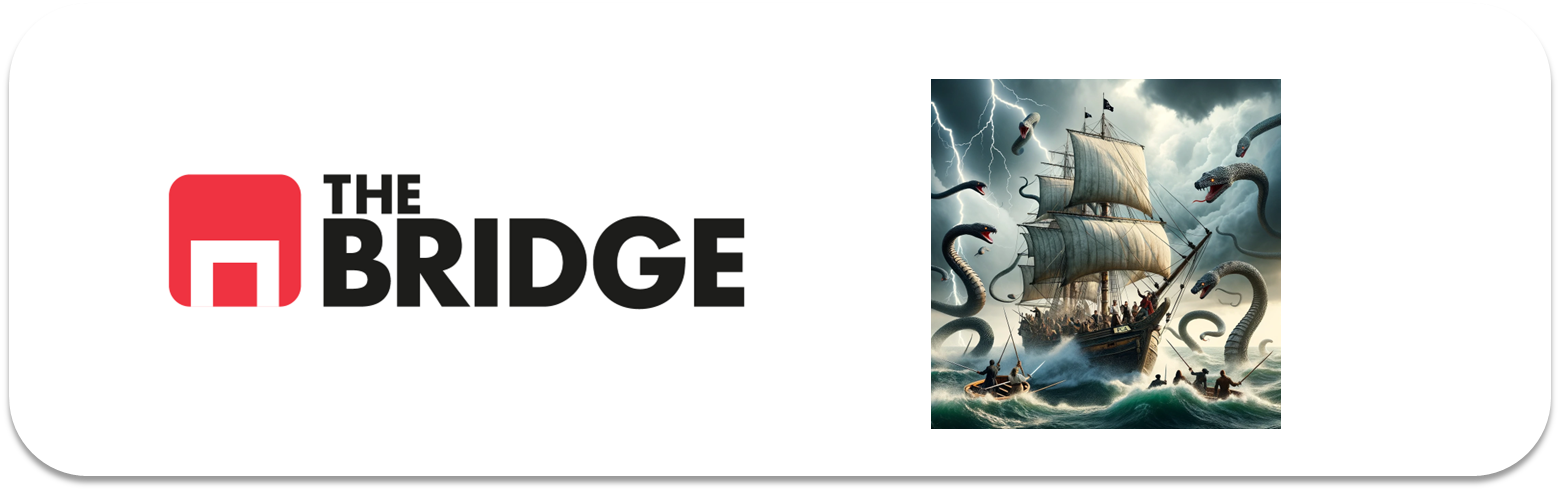

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [175]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import bootcampviztools as bt
import statsmodels.api as sm
import warnings
import sklearn
import os
import cv2

from matplotlib import style
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,  mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, silhouette_score, silhouette_samples, mutual_info_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, scale
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.utils import resample
from scipy import stats
from scipy.stats import mannwhitneyu

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

warnings.filterwarnings('ignore')
style.use('ggplot') or plt.style.use('ggplot')

In [88]:
df = pd.read_csv("./data/credit_npo.csv")

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [89]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [91]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,12537.000000,12537.000000,12537.000000,12537.000000,12537.000000,11816.000000,12537.000000,12537.000000,12537.000000,12537.000000,12360.000000
mean,0.068916,0.330359,52.079445,0.409588,1.902253,6864.815420,8.482332,0.259312,0.999202,0.228364,0.822087
std,0.253321,0.368148,15.077498,4.055787,9.122216,11855.905437,5.165422,4.035658,1.134325,4.018873,1.136802
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030651,41.000000,0.000000,0.142268,3498.750000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.163490,51.000000,0.000000,0.302025,5416.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.582219,62.000000,0.000000,0.506725,8300.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,6.000000,101.000000,98.000000,99.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


In [92]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

In [93]:
df["SeriousDlqin2yrs"].unique()
# A pesar de estar expresada numéricamente, tomo esta columna target como categórica

array([0, 1], dtype=int64)

In [94]:
# Ahora, transformar las numéricas en categóricas (hasta 3)

In [95]:
df["NumberOfTime30-59DaysPastDueNotWorse"].unique()
# Elimino outliers (98)
# categorías: 1: 0-2, 2: 3-5, 3: 6-7 o más?
# He hecho los histogramas de todos estos NumberOf... pero no veo que eso me revele ninguna info interesante para hacer el corte de los 3 segmentos

array([ 0,  3,  1,  2,  4, 98,  5,  6,  8,  7], dtype=int64)

In [96]:
df = df[df["NumberOfTime30-59DaysPastDueNotWorse"] != 98]

In [97]:
df["NumberOfTime30-59DaysPastDueNotWorse"].unique()

array([0, 3, 1, 2, 4, 5, 6, 8, 7], dtype=int64)

In [98]:
target = "SeriousDlqin2yrs"
cat_col = "SeriousDlqin2yrs"
num_col = "NumberOfTime30-59DaysPastDueNotWorse"

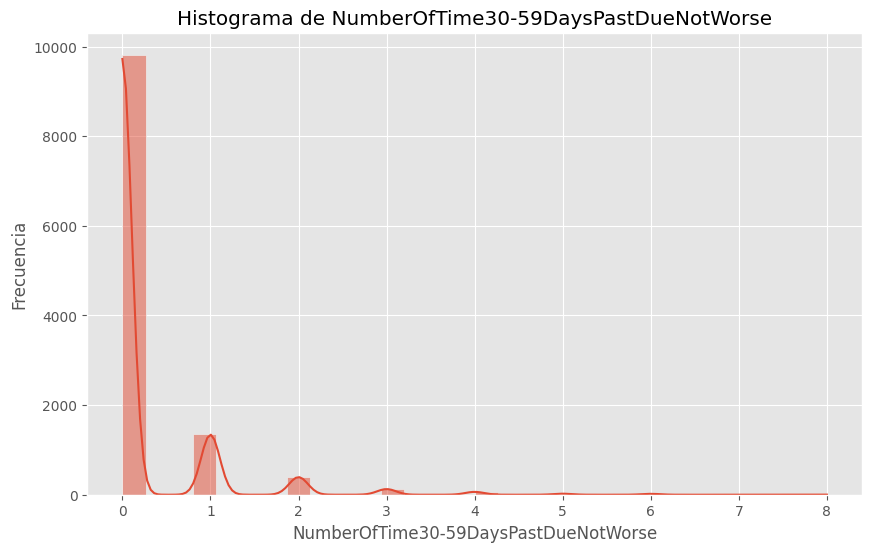

In [99]:
plt.figure(figsize=(10, 6))
sns.histplot(df["NumberOfTime30-59DaysPastDueNotWorse"], bins=30, kde=True)
plt.title('Histograma de NumberOfTime30-59DaysPastDueNotWorse')
plt.xlabel('NumberOfTime30-59DaysPastDueNotWorse')
plt.ylabel('Frecuencia')
plt.show()
# esto, solo, tampoco me da pistas de por donde hacer el corte, aunque bien podría ser 0 por un lado, 2 y 3 por otro, y el resto...

In [100]:
df['NumberOfTime30-59DaysPastDueNotWorse_Cat'] = np.nan

for index in df.index:
    value = df.at[index, 'NumberOfTime30-59DaysPastDueNotWorse']
    if value == 0:
        df.at[index, 'NumberOfTime30-59DaysPastDueNotWorse_Cat'] = 0
    elif value in [1, 2]:
        df.at[index, 'NumberOfTime30-59DaysPastDueNotWorse_Cat'] = 1
    else:
        df.at[index, 'NumberOfTime30-59DaysPastDueNotWorse_Cat'] = 2

In [101]:
df["NumberOfOpenCreditLinesAndLoans"].unique()
# Cat 1: 0-15, Cat 2: 16 - 30, Cat 3: 31 - 49.... aprox?

array([12,  9,  2,  4,  3,  5, 11,  8,  7, 13, 10,  1, 14,  6, 16, 15, 19,
       18, 17, 22, 20, 23, 29, 24, 27,  0, 21, 31, 30, 28, 38, 26, 25, 43,
       36, 34, 33, 35, 32, 48, 49, 41, 40], dtype=int64)

In [102]:
df["NumberOfOpenCreditLinesAndLoans"].value_counts().unique()

array([1110, 1031, 1009,  965,  963,  848,  765,  719,  638,  574,  454,
        445,  365,  338,  307,  236,  216,  151,  129,  118,  102,   62,
         61,   39,   38,   30,   19,   16,   13,   10,    7,    4,    3,
          2,    1], dtype=int64)

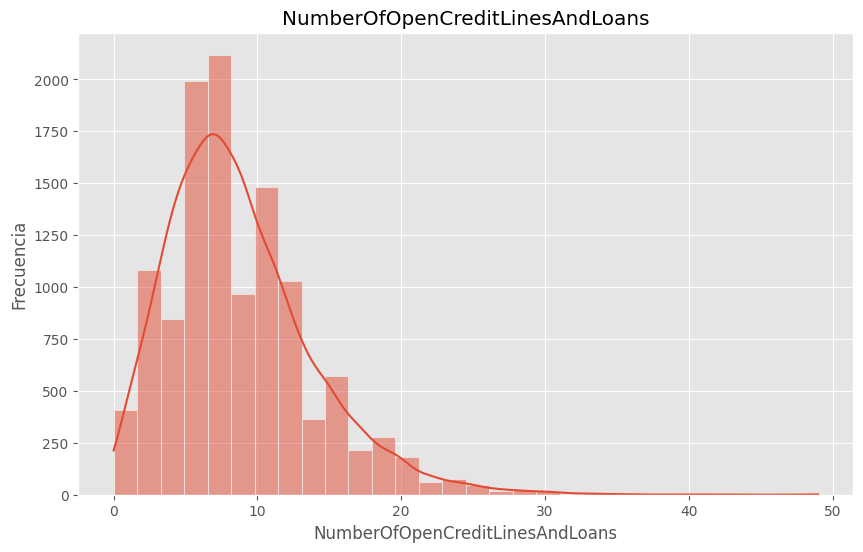

In [103]:
plt.figure(figsize=(10, 6))
sns.histplot(df["NumberOfOpenCreditLinesAndLoans"], bins=30, kde=True)
plt.title('NumberOfOpenCreditLinesAndLoans')
plt.xlabel('NumberOfOpenCreditLinesAndLoans')
plt.ylabel('Frecuencia')
plt.show()

In [104]:
df['NumberOfOpenCreditLinesAndLoans_Cat'] = np.nan

for index in df.index:
    value = df.at[index, 'NumberOfOpenCreditLinesAndLoans']
    if value > 14:
        df.at[index, 'NumberOfOpenCreditLinesAndLoans_Cat'] = 0
    elif value >22:
        df.at[index, 'NumberOfOpenCreditLinesAndLoans_Cat'] = 1
    else:
        df.at[index, 'NumberOfOpenCreditLinesAndLoans_Cat'] = 2

In [105]:
df["NumberOfTimes90DaysLate"].unique()
# Eliminé outliers más arriba (en ambas columnas la misma fila tenía valor "98") 
# categorías: 1: 0-4, 2: 5-9, 3: 10-13 o más


array([ 1,  0,  3,  2,  4,  6,  5,  8,  7, 10,  9, 13], dtype=int64)

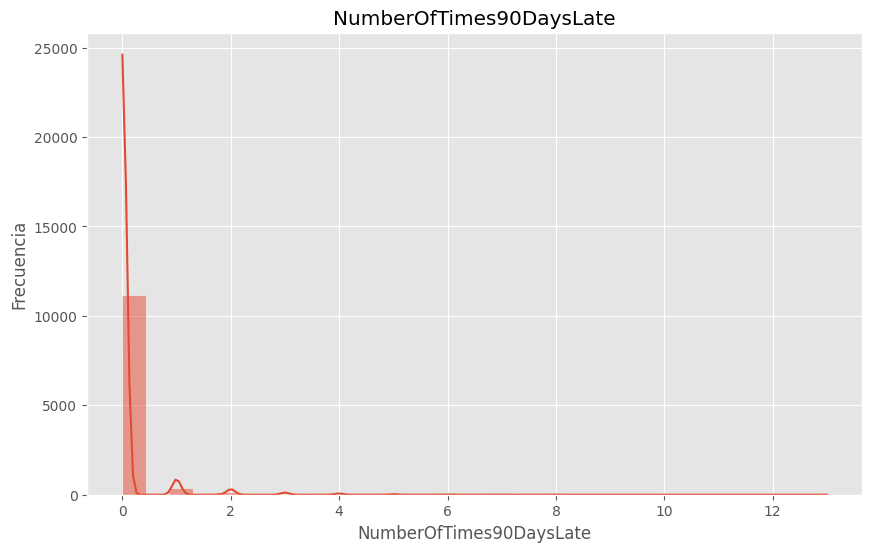

In [106]:
plt.figure(figsize=(10, 6))
sns.histplot(df["NumberOfTimes90DaysLate"], bins=30, kde=True)
plt.title('NumberOfTimes90DaysLate')
plt.xlabel('NumberOfTimes90DaysLate')
plt.ylabel('Frecuencia')
plt.show()

In [107]:
df['NumberOfTimes90DaysLate_Cat'] = np.nan

for index in df.index:
    value = df.at[index, 'NumberOfTimes90DaysLate']
    if value == 0:
        df.at[index, 'NumberOfTimes90DaysLate_Cat'] = 0
    elif value in [1, 2, 3, 4]:
        df.at[index, 'NumberOfTimes90DaysLate_Cat'] = 1
    else:
        df.at[index, 'NumberOfTimes90DaysLate_Cat'] = 2

In [108]:
df["NumberRealEstateLoansOrLines"].unique()
# mirar histograma
# categorías: 1: 0-6, 2: 7-12, 3: 13-19 o más

array([ 0,  1,  2,  4,  3,  6,  5,  7,  8, 19, 10,  9, 11, 16, 12, 13],
      dtype=int64)

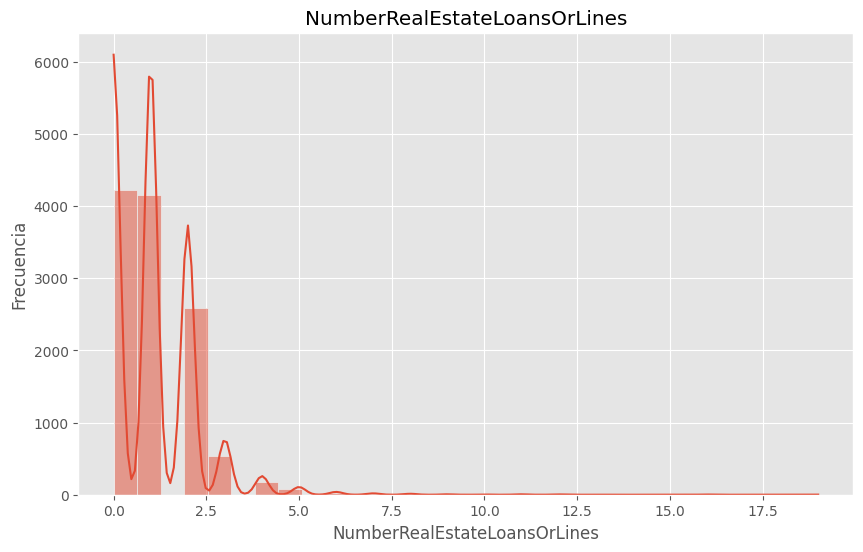

In [109]:
plt.figure(figsize=(10, 6))
sns.histplot(df["NumberRealEstateLoansOrLines"], bins=30, kde=True)
plt.title('NumberRealEstateLoansOrLines')
plt.xlabel('NumberRealEstateLoansOrLines')
plt.ylabel('Frecuencia')
plt.show()

In [110]:
df['NumberRealEstateLoansOrLines_Cat'] = np.nan

for index in df.index:
    value = df.at[index, 'NumberRealEstateLoansOrLines']
    if value < 2.5:
        df.at[index, 'NumberRealEstateLoansOrLines_Cat'] = 0
    elif value < 5:
        df.at[index, 'NumberRealEstateLoansOrLines_Cat'] = 1
    else:
        df.at[index, 'NumberRealEstateLoansOrLines_Cat'] = 2

In [111]:
df["NumberOfTime60-89DaysPastDueNotWorse"].unique()
# mirar histograma
# categorías: 1: 0-3, 2: 4-7, 3: 8-10 o más?

array([ 0,  2,  1,  3,  4,  5, 11], dtype=int64)

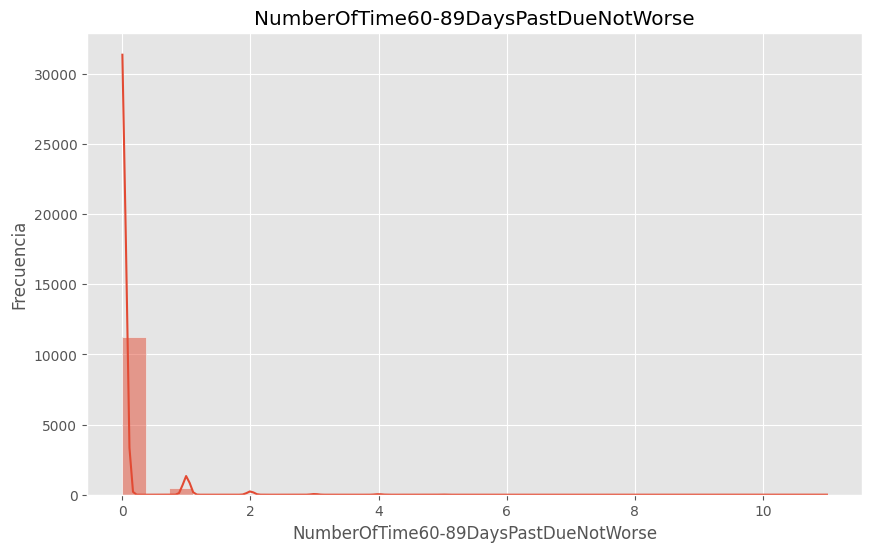

In [112]:
plt.figure(figsize=(10, 6))
sns.histplot(df["NumberOfTime60-89DaysPastDueNotWorse"], bins=30, kde=True)
plt.title('NumberOfTime60-89DaysPastDueNotWorse')
plt.xlabel('NumberOfTime60-89DaysPastDueNotWorse')
plt.ylabel('Frecuencia')
plt.show()

In [113]:
df['NumberOfDependents_Cat'] = np.nan

for index in df.index:
    value = df.at[index, 'NumberOfDependents']
    if value < 1:
        df.at[index, 'NumberOfDependents_Cat'] = 0
    elif value < 3:
        df.at[index, 'NumberOfDependents_Cat'] = 1
    else:
        df.at[index, 'NumberOfDependents_Cat'] = 2

In [114]:
df["NumberOfDependents"].unique()
# mirar histograma
# categorías: 1: 0-3, 2: 4-7, 3: 8-10 o más?

array([ 0.,  2.,  3.,  1.,  4.,  5.,  6.,  8., 10.,  7.])

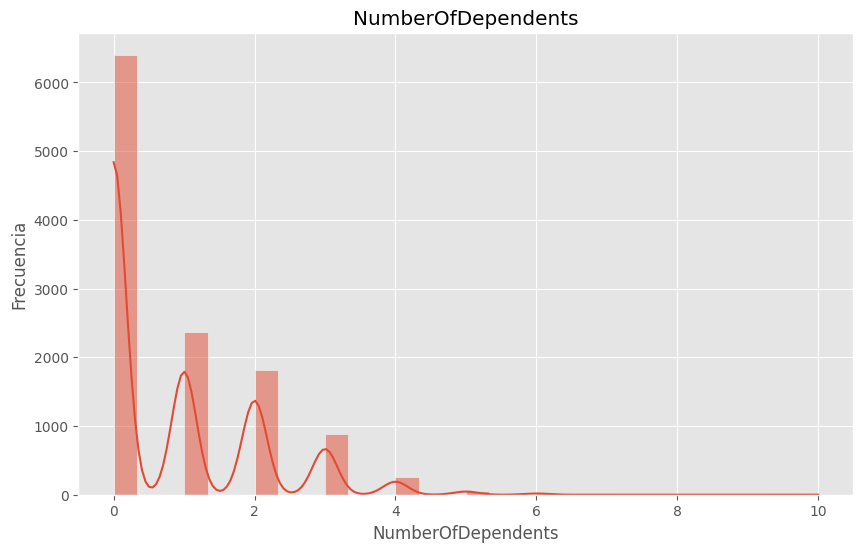

In [115]:
plt.figure(figsize=(10, 6))
sns.histplot(df["NumberOfDependents"], bins=30, kde=True)
plt.title('NumberOfDependents')
plt.xlabel('NumberOfDependents')
plt.ylabel('Frecuencia')
plt.show()

In [116]:
df['NumberOfDependents_Cat'] = np.nan

for index in df.index:
    value = df.at[index, 'NumberOfDependents']
    if value < 1:
        df.at[index, 'NumberOfDependents_Cat'] = 0
    elif value < 4:
        df.at[index, 'NumberOfDependents_Cat'] = 1
    else:
        df.at[index, 'NumberOfDependents_Cat'] = 2

In [117]:
# Mini EDA
# Los histogramas contra categórica no veo que me revelen nada especial, excepto los picos másximos

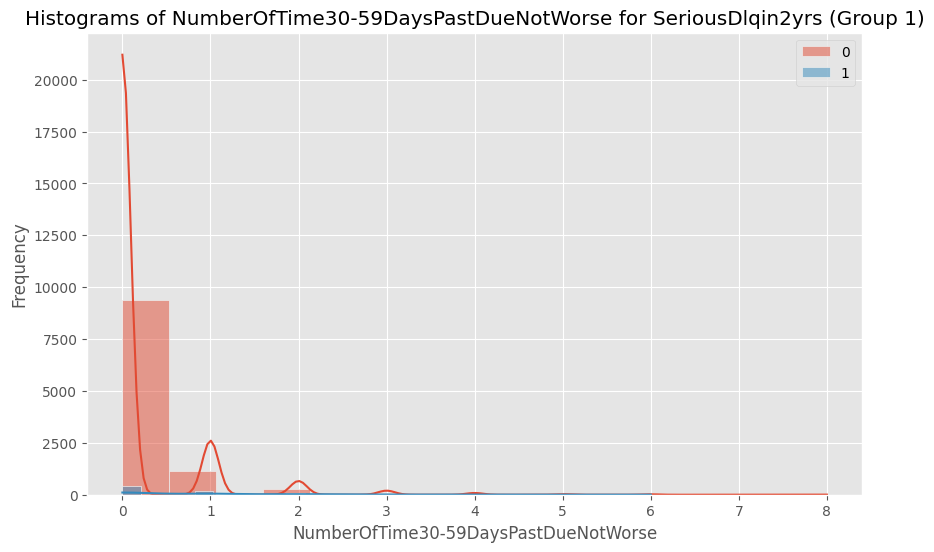

In [118]:
bt.plot_grouped_histograms(df,cat_col = target, num_col= num_col, group_size= 2)

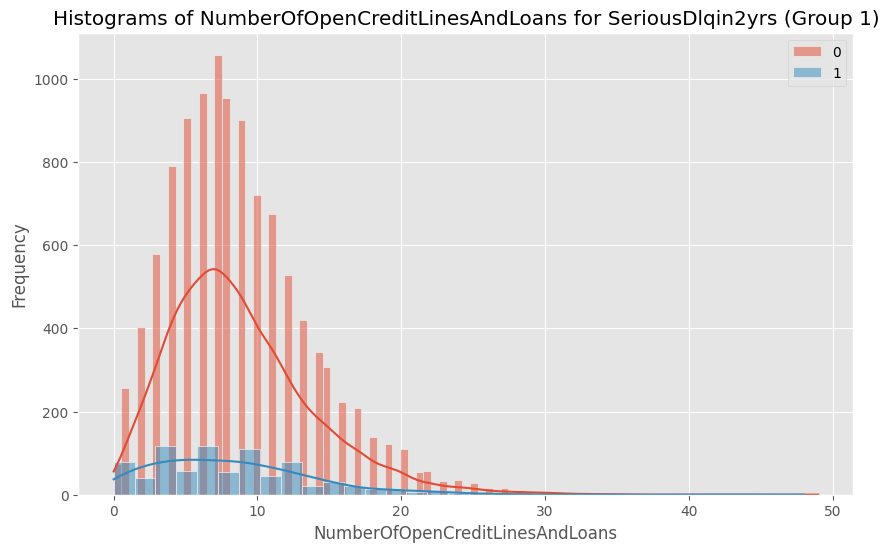

In [119]:
target = "SeriousDlqin2yrs"
num_col = "NumberOfOpenCreditLinesAndLoans"
bt.plot_grouped_histograms(df,cat_col = target, num_col= num_col, group_size= 2)

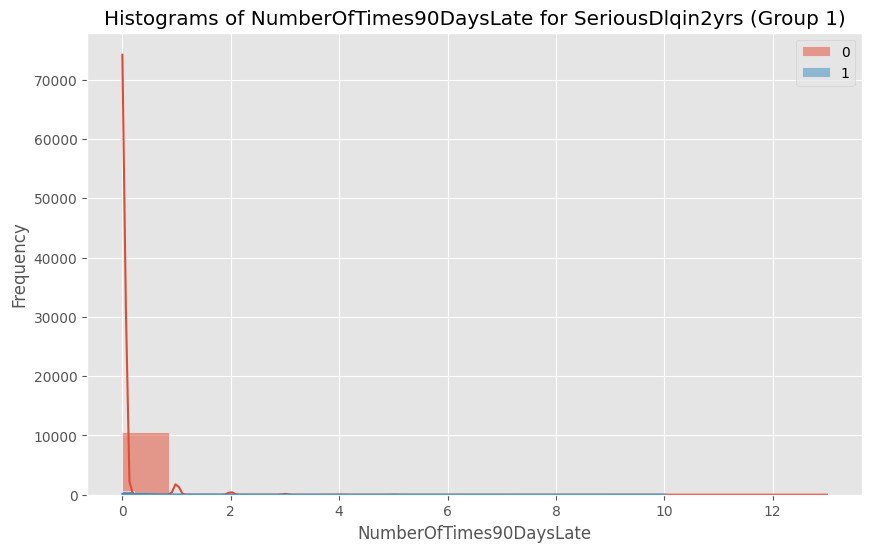

In [120]:
target = "SeriousDlqin2yrs"
num_col = "NumberOfTimes90DaysLate"
bt.plot_grouped_histograms(df,cat_col = target, num_col= num_col, group_size= 2)

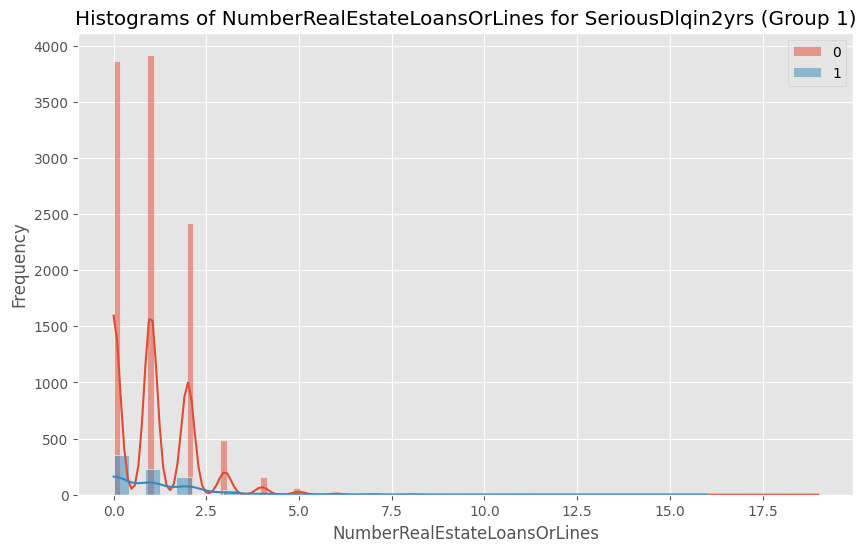

In [121]:
target = "SeriousDlqin2yrs"
num_col = "NumberRealEstateLoansOrLines"
bt.plot_grouped_histograms(df,cat_col = target, num_col= num_col, group_size= 2)

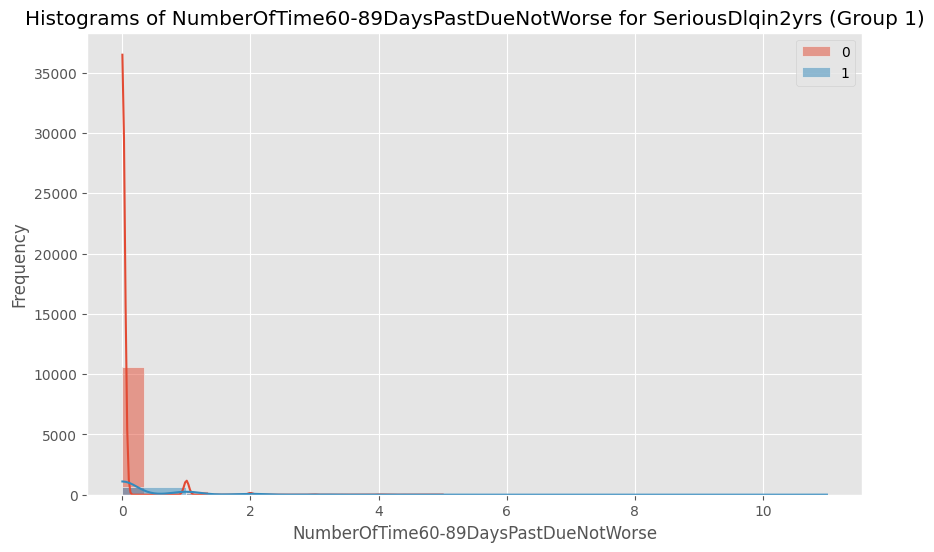

In [122]:
target = "SeriousDlqin2yrs"
num_col = "NumberOfTime60-89DaysPastDueNotWorse"
bt.plot_grouped_histograms(df,cat_col = target, num_col= num_col, group_size= 2)

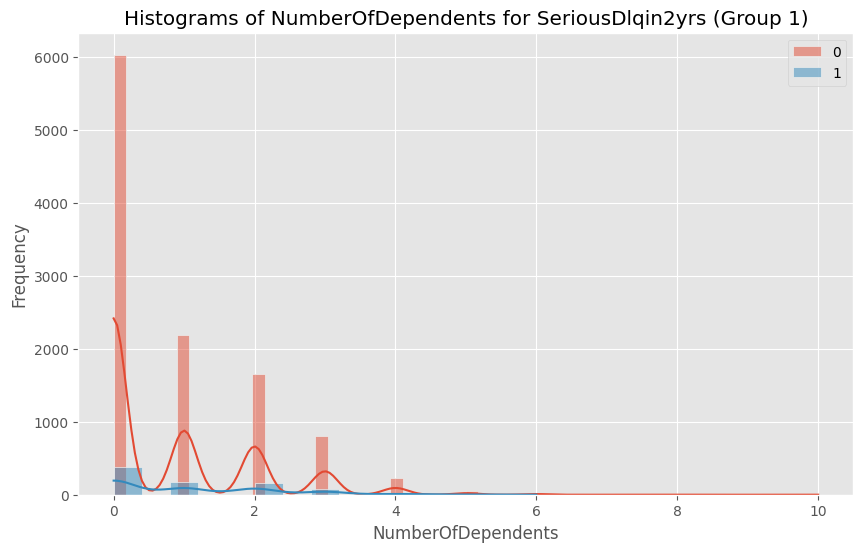

In [123]:
target = "SeriousDlqin2yrs"
num_col = "NumberOfDependents"
bt.plot_grouped_histograms(df,cat_col = target, num_col= num_col, group_size= 2)

In [124]:
# A ver si las correlaciones...

In [125]:
target = "SeriousDlqin2yrs"
features_num = df.columns.to_list()
features_num.remove(target)

In [126]:
cols_transformadas = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfOpenCreditLinesAndLoans', "NumberOfTimes90DaysLate", "NumberRealEstateLoansOrLines", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfDependents"] 
for col in cols_transformadas:
    features_num.remove(col)

In [127]:
corr = df[features_num + [target]].corr()
serie_corr = np.abs(corr[target])
serie_corr = serie_corr.drop(target)
serie_corr.sort_values(ascending = False)

NumberOfTimes90DaysLate_Cat                 0.347011
RevolvingUtilizationOfUnsecuredLines        0.278037
NumberOfTime30-59DaysPastDueNotWorse_Cat    0.246679
age                                         0.105705
NumberOfDependents_Cat                      0.044227
NumberRealEstateLoansOrLines_Cat            0.032589
MonthlyIncome                               0.021481
DebtRatio                                   0.001288
NumberOfOpenCreditLinesAndLoans_Cat         0.000665
Name: SeriousDlqin2yrs, dtype: float64

In [128]:
r_minimo = 0.10
features_num_sel = serie_corr[serie_corr >= r_minimo].index.to_list()
features_num_sel

# este corte en 0.10, ¿es arbitrario, es una convención general, hay algún criterio?

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse_Cat',
 'NumberOfTimes90DaysLate_Cat']

<Axes: >

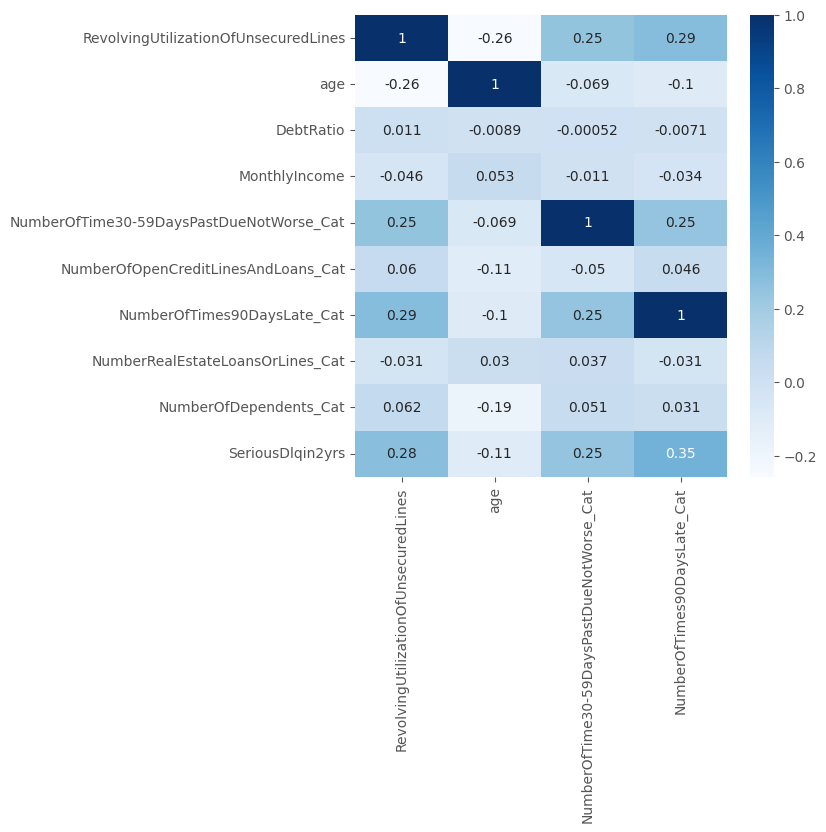

In [135]:
plt.figure(figsize=(6,6))
sns.heatmap(corr[features_num_sel], annot= True, cmap= "Blues")
# la orrelación es bastante flojita, no?

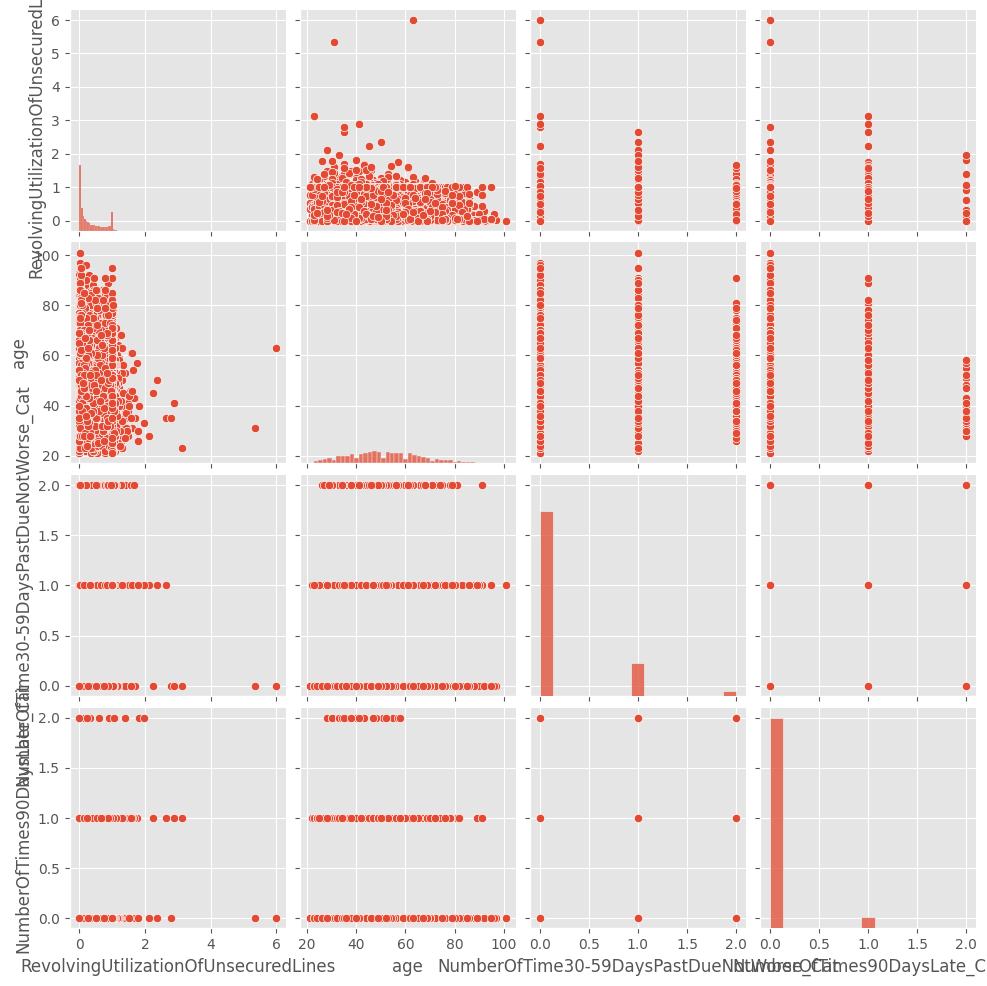

In [131]:
sns.pairplot(df[features_num_sel])
# esto no veo que me aporte nada...

In [ ]:
# ANOVA

In [142]:
cat_col = "SeriousDlqin2yrs"
deudores_cat = df[cat_col].unique()  
impago_revolving = [df[df[cat_col] == categoria]['RevolvingUtilizationOfUnsecuredLines'] for categoria in deudores_cat] 

In [143]:
f_val, p_val = stats.f_oneway(*impago_revolving) 
print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 988.9549097858907
Valor p: 1.569093900277169e-208


In [144]:
cat_col = "SeriousDlqin2yrs"
deudores_cat = df[cat_col].unique()  
impago_age = [df[df[cat_col] == categoria]['age'] for categoria in deudores_cat] 

In [145]:
f_val, p_val = stats.f_oneway(*impago_age) 
print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 133.38408054821056
Valor p: 1.089080335003241e-30


In [146]:
cat_col = "SeriousDlqin2yrs"
deudores_cat = df[cat_col].unique()  
impago_due30 = [df[df[cat_col] == categoria]['NumberOfTime30-59DaysPastDueNotWorse_Cat'] for categoria in deudores_cat] 

In [147]:
f_val, p_val = stats.f_oneway(*impago_due30) 
print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 764.8193838548688
Valor p: 3.5769154627233727e-163


In [149]:
cat_col = "SeriousDlqin2yrs"
deudores_cat = df[cat_col].unique()  
impago_due90 = [df[df[cat_col] == categoria]['NumberOfTimes90DaysLate_Cat'] for categoria in deudores_cat] 

In [150]:
f_val, p_val = stats.f_oneway(*impago_due90) 
print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 1615.9855695456954
Valor p: 0.0


In [ ]:
# Se confirma la relevancia de las 4 features para determiar su tendencia al impago

In [ ]:
# selectkbest (selección numéricas)

In [153]:
X_train = df[features_num]
y_train = df[target]
selector = SelectKBest(f_classif, k=5)
x_data_kbest = selector.fit_transform(X_train, y_train)
X_train_kbest = pd.DataFrame(x_data_kbest, columns = selector.get_feature_names_out())
X_train_kbest

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse_Cat,NumberOfTimes90DaysLate_Cat,NumberOfDependents_Cat
0,0.081892,37.0,0.0,1.0,0.0
1,0.023413,74.0,0.0,0.0,0.0
2,0.000000,43.0,0.0,0.0,1.0
3,0.492754,44.0,0.0,0.0,1.0
4,1.000000,63.0,0.0,0.0,1.0
...,...,...,...,...,...
11801,0.197116,59.0,0.0,0.0,0.0
11802,0.036726,62.0,0.0,0.0,0.0
11803,0.120313,49.0,0.0,0.0,1.0
11804,0.252566,63.0,0.0,0.0,1.0


In [ ]:
# Nos está dando las mismas columnas que el método anterior (bueno, 1 más porque aquí he puesto 5, no 4)

In [ ]:
# El de Mann también, ya puestos... por qué no... para las mismas 4 features que salieron del ANOVA

In [157]:
cat_col = "SeriousDlqin2yrs"
num_col = "RevolvingUtilizationOfUnsecuredLines"

grupo_a = df.loc[df[cat_col] == 0][num_col]
grupo_b = df.loc[df[cat_col] == 1][num_col]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 2036348.0
Valor p: 7.176947250656466e-153


In [158]:
cat_col = "SeriousDlqin2yrs"
num_col = "age"

grupo_a = df.loc[df[cat_col] == 0][num_col]
grupo_b = df.loc[df[cat_col] == 1][num_col]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 5624294.5
Valor p: 1.039116399799085e-31


In [159]:
cat_col = "SeriousDlqin2yrs"
num_col = "NumberOfTime30-59DaysPastDueNotWorse_Cat"

grupo_a = df.loc[df[cat_col] == 0][num_col]
grupo_b = df.loc[df[cat_col] == 1][num_col]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 2981576.5
Valor p: 3.363695105566811e-139


In [160]:
cat_col = "SeriousDlqin2yrs"
num_col = "NumberOfTimes90DaysLate_Cat"

grupo_a = df.loc[df[cat_col] == 0][num_col]
grupo_b = df.loc[df[cat_col] == 1][num_col]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 3136938.0
Valor p: 2.222163731705209e-301


In [ ]:
# Todos los p-values indican que las features elegidas sí que son interesantes
# ¿ Hay que contrastar ambos resultados? ¿Tiene sentido hacer ambos tests?

In [ ]:
# Mutual information (seleccion categóricas)

In [162]:
df.columns.to_list()
# por qué aquñi me falta una de las columnas cat??

['SeriousDlqin2yrs',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents',
 'NumberOfTime30-59DaysPastDueNotWorse_Cat',
 'NumberOfOpenCreditLinesAndLoans_Cat',
 'NumberOfTimes90DaysLate_Cat',
 'NumberRealEstateLoansOrLines_Cat',
 'NumberOfDependents_Cat']

In [ ]:
# estas categóricas con números las estoy usando en tests y correlaciones, etc, tanto como numéricas como como c
# ategóricas... diría que estoy haciendo algo más o como mínimo de más...

In [163]:
features_cat = ["NumberOfTime30-59DaysPastDueNotWorse_Cat","NumberOfOpenCreditLinesAndLoans_Cat","NumberOfTimes90DaysLate_Cat","NumberRealEstateLoansOrLines_Cat", "NumberOfDependents_Cat", "NumberOfTime30-59DaysPastDueNotWorse_Cat"]
target = "SeriousDlqin2yrs"
df_mi = df.dropna()
for col in features_cat:
    print(f"MI({col};{target}):", mutual_info_score(df_mi[col],df_mi[target]))

MI(NumberOfTime30-59DaysPastDueNotWorse_Cat;SeriousDlqin2yrs): 0.02146843181285394
MI(NumberOfOpenCreditLinesAndLoans_Cat;SeriousDlqin2yrs): 2.2060678268875922e-07
MI(NumberOfTimes90DaysLate_Cat;SeriousDlqin2yrs): 0.031727791984270975
MI(NumberRealEstateLoansOrLines_Cat;SeriousDlqin2yrs): 0.0005412462483540634
MI(NumberOfDependents_Cat;SeriousDlqin2yrs): 0.0010694440379802952
MI(NumberOfTime30-59DaysPastDueNotWorse_Cat;SeriousDlqin2yrs): 0.02146843181285394


In [ ]:
# Puesto que a mayor coeficiente, mayor importancia:
# en primer lugar queda NumberOfTimes90DaysLate_Cat con 0.031727791984270975
# en 2do lugar NumberOfTime30-59DaysPastDueNotWorse_Cat 
# le sigue NumberOfDependents_Cat en 4ta posición
# En 5to NumberRealEstateLoansOrLines_Cat
# Y en último lugar NumberOfOpenCreditLinesAndLoans_Cat

In [ ]:
# Selector de modelo

In [165]:
lr_selector = LogisticRegression(max_iter = 1000)
rf_selector = RandomForestClassifier(random_state= 42)

In [166]:
rf_selector.fit(df[features_num],df["SeriousDlqin2yrs"])

RandomForestClassifier(random_state=42)

In [167]:
rf_selector.feature_importances_[rf_selector.feature_importances_ > rf_selector.feature_importances_.mean()]

array([0.24999548, 0.14968526, 0.20803138, 0.19976501])

In [168]:
selector_model = SelectFromModel(estimator = rf_selector, threshold= "median")

In [169]:
selector_model.fit(df[features_num],df["SeriousDlqin2yrs"]) 

SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median')

In [171]:
selector_model.get_feature_names_out()
# En este caso varía la selección de las features importantes: hay 3 que coinciden, pero no las otras dos que 
# hasta ahora no habían aparecido con los otros métodos / filtros

array(['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfTimes90DaysLate_Cat'], dtype=object)

In [172]:
X_train_model = pd.DataFrame(selector_model.transform(df[features_num]), columns = selector_model.get_feature_names_out())
X_train_model

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfTimes90DaysLate_Cat
0,0.081892,37.0,0.070709,5656.0,1.0
1,0.023413,74.0,0.209197,4870.0,0.0
2,0.000000,43.0,0.080784,5000.0,0.0
3,0.492754,44.0,0.412735,7333.0,0.0
4,1.000000,63.0,0.000000,8333.0,0.0
...,...,...,...,...,...
11801,0.197116,59.0,0.290216,5140.0,0.0
11802,0.036726,62.0,0.884985,5833.0,0.0
11803,0.120313,49.0,0.577676,6333.0,0.0
11804,0.252566,63.0,0.037640,14000.0,0.0


In [173]:
df["SeriousDlqin2yrs"].value_counts()
# Es MUY desbalanceado

SeriousDlqin2yrs
0    10983
1      823
Name: count, dtype: int64

In [174]:
for nombre,set in zip(["Selected from Random Forest", "Selected by ANOVA", "Full num features"],[X_train_model, X_train_kbest, X_train[features_num]]):
    print(f"Para el dataset <{nombre}>: num_features: {len(set.columns.to_list())}, score", sep = " ")
    print(np.mean(cross_val_score(lr_selector, set, y_train, cv = 5, scoring = "balanced_accuracy")))


Para el dataset <Selected from Random Forest>: num_features: 5, score
0.5625899040621909
Para el dataset <Selected by ANOVA>: num_features: 5, score
0.5738159824873423
Para el dataset <Full num features>: num_features: 9, score
0.5730093365154133


In [ ]:
# El resultado de ANOVA es el mejor, no solo tiene la mejor métrica sino que además es más sencillo con menos 
# features que con las features full

In [ ]:
# Ahora con RFE

In [176]:
X_train_deudas = df[features_num].copy()
y_train_deudas = df["SeriousDlqin2yrs"]

In [178]:
rf_RFE = RandomForestClassifier(random_state= 42) 
rfe = RFE(estimator = rf_RFE,
          n_features_to_select= 5,
          step = 1)

rfe.fit(X_train_deudas, y_train_deudas)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_, columns= ["ranking"], index = features_num).sort_values("ranking")

[1 1 1 1 2 4 1 5 3]


,ranking
RevolvingUtilizationOfUnsecuredLines,1
age,1
DebtRatio,1
MonthlyIncome,1
NumberOfTimes90DaysLate_Cat,1
NumberOfTime30-59DaysPastDueNotWorse_Cat,2
NumberOfDependents_Cat,3
NumberOfOpenCreditLinesAndLoans_Cat,4
NumberRealEstateLoansOrLines_Cat,5


In [179]:
print("Seleccionadas por modelo:", list(selector_model.get_feature_names_out()))
# da lo mismo que el selector de arriba

Seleccionadas por modelo: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'NumberOfTimes90DaysLate_Cat']


In [180]:
print("Seleccionadas por ANOVA:", X_train_kbest.columns.to_list())
# como puse más arriba, la selección de ambos modelos da 3 features en común.

Seleccionadas por ANOVA: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse_Cat', 'NumberOfTimes90DaysLate_Cat', 'NumberOfDependents_Cat']


In [ ]:
# Ahora con SFS

In [181]:
rf_SFS = RandomForestClassifier(random_state = 42)

sfs_forward = SequentialFeatureSelector(rf_SFS,
                                        n_features_to_select = 5,
                                        cv = 4,
                                        scoring = "balanced_accuracy")


sfs_forward.fit(X_train_deudas, y_train_deudas)

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(random_state=42),
                          n_features_to_select=5, scoring='balanced_accuracy')

In [182]:
print("Elegidasd SFS:", sfs_forward.get_feature_names_out())

Elegidasd SFS: ['RevolvingUtilizationOfUnsecuredLines' 'MonthlyIncome'
 'NumberOfTime30-59DaysPastDueNotWorse_Cat'
 'NumberOfOpenCreditLinesAndLoans_Cat' 'NumberOfTimes90DaysLate_Cat']


In [ ]:
# Hard voting

In [ ]:
# Si hacemos un hard voting de las features que más han salido como relevantes, nos quedaríamos con:
# NumberOfTimes90DaysLate_Cat' en primer lugar
# 'RevolvingUtilizationOfUnsecuredLines' en el 2do lugar
# 'MonthlyIncome',  en 3er lugar
# NumberOfTime30-59DaysPastDueNotWorse_Cat' en 4to lugar

# Me parece que puede haber algún error en esto que viene de las pruebas para numéricas o categóricas... 
# me parece que las solo numéricas las numéricas las he testeado menos... a revisar

In [ ]:
# Comparativa de modelos con cv

In [ ]:
model_names = ["Model Seletion","SFS","RFE"]

# ms = LogisticRegression(max_iter = 10000)
# sfs = KNeighborsClassifier(2)
# rfe = RandomForestClassifier(random_state= 42)

model_set = [ms, sfs, rfe]

# No sé cómo hacer esta parte, no acabo de entender qué / cómo hacer en este punto...

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.

In [ ]:
# y esto menos aún, aún tengo el mareo de la práctica de la unidad 1 de PCA